In [23]:
import torch, time, gc
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid

In [24]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_PATH = "./neural_net.pth"

In [25]:
# Training variables
BATCH_SIZE = 32
EPOCHS = 60
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 5e-4

In [26]:
IMG_SIZE = (224, 244)
# Transformations for test/val datasets
transform_test = transforms.Compose([
  transforms.Resize(IMG_SIZE, antialias=True),
  transforms.ToTensor()
])

# Transformations for train dataset
transform_train = transforms.Compose([
  transforms.Resize(IMG_SIZE, antialias=True),
  transforms.RandomHorizontalFlip(),
  # transforms.RandomRotation(30),  # decreased from 90 because training accuracy was v low
  transforms.ToTensor()
])

In [27]:
# Load datasets
train_dataset = datasets.Flowers102(root="./data", split="train", transform=transform_train, download=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = datasets.Flowers102(root="./data", split="test", transform=transform_test, download=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

val_dataset = datasets.Flowers102(root="./data", split="val", transform=transform_test, download=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [28]:
train_accuracies = []
val_accuracies = []

In [29]:
# CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv0 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU())   # new conv layer 64
        self.conv1 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2)) # 224 -> 112
        self.conv2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2)) # 112 -> 56
        # self.conv3 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        #                            nn.BatchNorm2d(128),
        #                            nn.ReLU())
        self.conv4 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2)) # 56 -> 28
        self.conv5 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(256),
                                   nn.ReLU())
        # self.conv6 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        #                            nn.BatchNorm2d(256),
        #                            nn.ReLU())
        self.conv7 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(256),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2)) # 28 -> 14
        self.conv8 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(512),
                                   nn.ReLU())
        # self.conv9 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        #                            nn.BatchNorm2d(512),
        #                            nn.ReLU()) # new conv layer 512
        # self.conv10 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
        #                            nn.BatchNorm2d(512),
        #                            nn.ReLU()) # new conv layer 512
        self.conv11 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                                   nn.BatchNorm2d(512),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2)) # 14 -> 7
        self.flatten = nn.Flatten()
        self.fc1 = nn.Sequential(nn.Linear(7 * 7 * 512, 4096),
                                   nn.ReLU(),
                                   nn.Dropout(p=0.5))
        self.fc2 = nn.Sequential(nn.Linear(4096, 1024), # originally 4096 out
                                   nn.ReLU(),
                                   nn.Dropout(p=0.5))
        # self.fc3 = nn.Sequential(nn.Linear(1024, 512),  # originally 1024 out
        #                            nn.ReLU(),
        #                            nn.Dropout(p=0.5)) # new linear layer
        self.fc4 = nn.Sequential(nn.Linear(1024, 102))

    def forward(self, x):
        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)
        # x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        # x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        # x = self.conv9(x)
        # x = self.conv10(x)
        x = self.conv11(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        # x = self.fc3(x)
        x = self.fc4(x)
        return x

In [30]:
# Clear cuda cache
gc.collect()
torch.cuda.empty_cache()

In [31]:
# Create an instance of the CNN and move it to the device
cnn = CNN().to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

from torchsummary import summary
summary(cnn, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
        MaxPool2d-11          [-1, 128, 56, 56]               0
           Conv2d-12          [-1, 128, 56, 56]         147,584
      BatchNorm2d-13          [-1, 128, 56, 56]             256
             ReLU-14          [-1, 128,

In [32]:
# Calculate accuracy, called with any loader
def calc_acc(loader):
  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = cnn(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
  return accuracy

In [33]:
start_time = time.time()

# Train CNN
for epoch in range(EPOCHS):
  print(f"---------- {epoch + 1} ----------")
  print("  Training network...")
  total = 0
  correct = 0
  cnn.train()
  for i, (images, labels) in enumerate(train_loader):
    labels = torch.eye(102)[labels] # one hot encode
    images = images.to(device)
    labels = labels.to(device)

    outputs = cnn(images) # train
    labels = torch.argmax(labels, dim=1) # one hot decode
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()  

    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  accuracy = 100 * correct / total
  print(f"    Training accuracy: {accuracy:.3f}%")
  train_accuracies.append(accuracy)

  print("  Calculating accuracy...")
  cnn.eval()
  accuracy = calc_acc(val_loader)
  print(f"    Validation accuracy: {accuracy:.3f}%")
  val_accuracies.append(accuracy)

end_time = time.time()
print("Training complete in: " + time.strftime("%Hh %Mm %Ss", time.gmtime(end_time - start_time)))


---------- 1 ----------
  Training network...
    Training accuracy: 1.275%
  Calculating accuracy...
    Validation accuracy: 1.275%
---------- 2 ----------
  Training network...
    Training accuracy: 1.569%
  Calculating accuracy...
    Validation accuracy: 7.255%
---------- 3 ----------
  Training network...
    Training accuracy: 2.549%
  Calculating accuracy...
    Validation accuracy: 8.333%
---------- 4 ----------
  Training network...
    Training accuracy: 5.490%
  Calculating accuracy...
    Validation accuracy: 11.569%
---------- 5 ----------
  Training network...
    Training accuracy: 7.745%
  Calculating accuracy...
    Validation accuracy: 15.196%
---------- 6 ----------
  Training network...
    Training accuracy: 9.020%
  Calculating accuracy...
    Validation accuracy: 15.098%
---------- 7 ----------
  Training network...
    Training accuracy: 11.765%
  Calculating accuracy...
    Validation accuracy: 18.137%
---------- 8 ----------
  Training network...
    Trainin

In [34]:
print("---------- Testing ----------")
print(" Calculating accuracy...")
accuracy = calc_acc(test_loader)
print(f"   Testing accuracy: {accuracy:.3f}%")

---------- Testing ----------
 Calculating accuracy...
   Testing accuracy: 45.373%


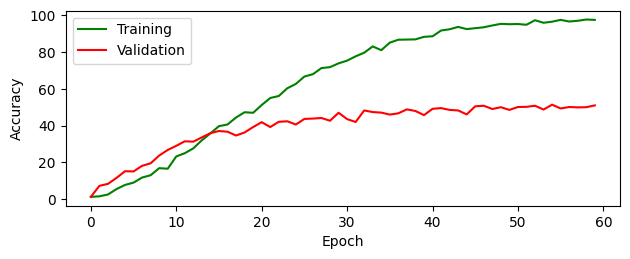

In [35]:
# Plot
fig = plt.figure(tight_layout=True)
gs = grid.GridSpec(nrows=2, ncols=1)

ax = fig.add_subplot(gs[0,0])
ax.plot(train_accuracies, label="Training", color="green")
ax.plot(val_accuracies, label="Validation", color="red")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")

fig.align_labels()
plt.legend()
plt.show()